<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house['MSZoning'].value_counts()

# note: there are 10 rows of non-residential to drop

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
# dropping all non-residential
house_nr = house[house['MSZoning'] == 'C (all)']
house = house.drop(house_nr.index)

In [ ]:
print house.shape

In [ ]:
house.isnull().sum().sort_values(ascending=False)
# drop MiscFeature, Id

In [6]:
house.drop('Id', axis=1, inplace=True)

In [ ]:
house.head(3)

In [ ]:
house.tail(3)

In [ ]:
# house.columns[house.dtypes != 'object'].values

In [ ]:
sns.set(style="white")
corr = house.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(120, 10, as_cmap=True)
plt.figure(figsize=(35,20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, cbar=False)

In [7]:
house.columns[house.dtypes == 'object'].values

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'], dtype=object)

In [8]:
corr=house.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]].head()

SalePrice      1.000000
OverallQual    0.789031
GrLivArea      0.708658
GarageCars     0.642135
GarageArea     0.629831
Name: SalePrice, dtype: float64

In [9]:
# categorical features, non-numeric

house_cat = house[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'SaleType', 'SaleCondition', 'MSSubClass', 'MiscFeature']]

# not categorical, but numerical features

house_num = house[['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice']]

In [10]:
# categorical, ordinal values
house_ord = house.drop(house_cat, axis=1)
house_ord = house_ord.drop(house_num, axis=1)

In [11]:
house_ord.columns.values

array(['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'], dtype=object)

In [12]:
print house_ord.shape
print house_num.shape
print house_cat.shape

(1450, 11)
(1450, 25)
(1450, 44)


In [ ]:
house_cat.isnull().sum().sort_values(ascending=False).head(20)

In [13]:
# Ok to change NaN to 'Nil' as further check shows they mean variable is not available at property

house_cat.fillna('Nil', inplace=True)

C:\Users\Arsyad\Anaconda2\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [ ]:
house_num.isnull().sum().sort_values(ascending=False).head()

In [14]:
# dropping GarageYrBlt as it has high correlation with YearBuilt. Does not make sense to put 0 for houses with no garage
# as col is showing as year

house_num.drop('GarageYrBlt', axis=1, inplace=True)

C:\Users\Arsyad\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
# filling LotFrontage as 0. Would indicate that there is no LotFrontage

house_num.fillna(0, inplace=True)

In [ ]:
house_num.isnull().sum()

In [ ]:
house_ord.isnull().sum()

# no null values to change for house_ord

In [ ]:
# see distribution of numerical features

plt.figure()
house.hist(layout=(8,5), bins=30, figsize=(20,25))

# SalePrice is slightly skewed to the right. Note: may need to apply log function during regression

In [ ]:
# see relation of sqft with SalePrice
plt.figure(figsize=(1,1))
sns.lmplot('GrLivArea', 'SalePrice', house_1)

In [ ]:
# see relation of house_age with SalePrice
plt.figure(figsize=(5,5))
sns.regplot('house_age', 'SalePrice', house_1)

In [ ]:
# see relation of Garage Area with SalePrice
plt.figure(figsize=(1,1))
sns.lmplot('GarageArea', 'SalePrice', house_1)

In [ ]:

plt.figure(figsize=(1,1))
sns.lmplot('TotalBsmtSF', 'SalePrice', house_1)

In [ ]:
plt.figure(figsize=(1,1))
sns.lmplot('Fireplaces', 'SalePrice', house_1)

In [ ]:
corr1=house_clean.corr()["SalePrice"]
corr1[np.argsort(corr1, axis=0)[::-1]]

In [ ]:
# Categorical columns: Street, Alley, LotShape, LandContour, Utillities, LandConfig, LandSlope, Neighborhood, 
# Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, RoofStyle, RoofMatl, Exterior1st,
# Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1,
# BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces
# GarageType, GarageFinish, GarageCars, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature,
# SaleType, SaleCondition, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath
# total: 52

In [ ]:
# house_cat = house[['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
# 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
# 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
# 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
# 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence','SaleType', 
# 'SaleCondition', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'FireplaceQu', 'MSZoning', 'BedroomAbvGr',
# 'KitchenAbvGr', 'MSSubClass']]

In [16]:
house_clean = pd.concat([house_num, house_cat, house_ord], axis=1)

In [17]:
house_clean['MSSubClass'] = house_clean['MSSubClass'].apply(lambda x: str(x))

In [18]:
# get age of house

house_clean['house_age'] = house_clean['YrSold'] - house_clean['YearBuilt']

In [19]:
# determining the fixed features

# draft fixed features
fixed_feature_ = house_clean[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotShape', 'LotArea', 'Street', 'Alley', 'LandContour', 
               'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
               'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
               'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 
               'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
               'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 
               ]]

# confirmed fixed values

# YearRemodAdd, YearBuilt, house_age

fixed_feat = house_clean[['MSSubClass', 'Street', 'LotConfig', 'Condition2', 'Foundation', 'HalfBath',
                   'MSZoning', 'BldgType', 'BsmtQual', 'BsmtFullBath', 'BedroomAbvGr', 'GarageType', 'PoolArea', 
                    'LotFrontage', 'Neighborhood', 'HouseStyle', 'TotalBsmtSF', 'BsmtHalfBath', 'KitchenAbvGr', 
                    'MiscFeature', 'LotShape', 'LandContour', 'Condition1', 'MasVnrType', '2ndFlrSF', 'TotRmsAbvGrd',
                   '1stFlrSF', 'FullBath', 'GrLivArea', 'GarageArea', 'MiscVal', 'LotArea', 'Utilities', 'GarageCars',
                   'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'Alley', 'LandSlope', 'house_age', 'YearRemodAdd',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'RoofStyle'
                         ]]

In [20]:
test = house_clean.drop(fixed_feat, axis=1)
print test.shape
print fixed_feat.shape

(1450, 33)
(1450, 47)


In [21]:
# creating dummy variable for categories cols

fixed_feat_dummy = pd.get_dummies(fixed_feat, drop_first=True)
fixed_feat_dummy.shape

(1450, 138)

In [22]:
house_1 = pd.concat([fixed_feat_dummy, house['YrSold'], house['SalePrice']], axis=1)
print house_1.shape

(1450, 140)


In [23]:
# to filter based on Yrsold to split for test and prediction set

house_Yrb4_2010 = house_1[house_1['YrSold'] < 2010]
house_Yr_2010 = house_1[house_1['YrSold'] == 2010]
print house_Yrb4_2010.shape
print house_Yr_2010.shape

(1278, 140)
(172, 140)


In [24]:
house_Yrb4_2010.drop('YrSold', axis=1, inplace=True)
house_Yr_2010.drop('YrSold', axis=1, inplace=True)

C:\Users\Arsyad\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Arsyad\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
cols = list(house_Yrb4_2010.columns)
cols.remove('SalePrice')

# house_train_target = house_Yrb4_2010['SalePrice']
# house_train_pred = house_Yrb4_2010.drop('SalePrice', axis=1)

y_train = house_Yrb4_2010['SalePrice']
X_train = house_Yrb4_2010.drop('SalePrice', axis=1)

y_test = house_Yr_2010['SalePrice']
X_test = house_Yr_2010.drop('SalePrice', axis=1)

In [ ]:
# sns.set(style="white")
# corr = fixed_feat.corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plt.figure(figsize=(35,20))
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.1f',
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, cbar=False)

In [ ]:
# see distribution of chosen fixed features

corr = house_1.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]].head()

# plt.figure()
# house_1.hist(layout=(30,5), bins=30, figsize=(20,25))

In [26]:
# importing all the sklearn modules

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

C:\Users\Arsyad\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
ss = StandardScaler()

Xs_train = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns.values)
Xs_test = pd.DataFrame(ss.fit_transform(X_test), columns=X_train.columns.values)

mm = MinMaxScaler()

# Xs_train = pd.DataFrame(mm.fit_transform(X_train), columns=X_train.columns.values)
# Xs_test = pd.DataFrame(mm.fit_transform(X_test), columns=X_test.columns.values)

In [28]:
lm = LinearRegression()
model = lm.fit(Xs_train, y_train)

print model.score(Xs_test, y_test)
print model.intercept_

-5.835066894409498e+24
181989.78247261344


In [ ]:
# from sklearn.linear_model import LinearRegression
# from sklearn import metrics

# lm = LinearRegression()
# model = lm.fit(Xs_train, y_train)

# predictions = model.predict(Xs_test)
# print "R^2 Score: ", metrics.r2_score(y_test, predictions)

In [ ]:
# # baseline model

# Xs_train1 = np.concatenate([Xs_train, np.ones((Xs_train.shape[0], 1))], axis=1)
# Xs_test1 = np.concatenate([Xs_test, np.ones((Xs_test.shape[0], 1))], axis=1)
# model1 = sm.OLS(y_train, Xs_train)
# model1 = model.fit()
# prediction = model1.predict()
# model.summary()

In [ ]:
len(X_train.columns)

### Running Lasso Reg

In [29]:
# lasso feature selection with house_age

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xs_train, y_train)

print 'Optimal Lasso Alpha: ', optimal_lasso.alpha_

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print 'lasso scores:', lasso_scores
print 'Mean lasso scores:', np.mean(lasso_scores)

Optimal Lasso Alpha:  676.5605011343918
lasso scores: [0.88991442 0.83796334 0.8661984  0.74044028 0.82980373 0.71586157
 0.8899007  0.81947596 0.47743729 0.83611817]
Mean lasso scores: 0.7903113859422126


In [30]:
#Lasso feature selection/variable selection alternative with house_age

lasso = lasso.fit(Xs_train, y_train)
lasso_coefs = pd.DataFrame({'var': X_train.columns,
                          'coef':lasso.coef_,
                          'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', ascending=False)

,abs_coef,coef,var
12,30281.260971,30281.260971,GrLivArea
66,14462.122345,-14462.122345,BsmtQual_Gd
68,13829.960867,-13829.960867,BsmtQual_TA
90,11316.237358,11316.237358,Neighborhood_NridgHt
16,9498.461252,9498.461252,GarageCars
89,8773.707858,8773.707858,Neighborhood_NoRidge
20,7535.551027,-7535.551027,house_age
96,7196.629578,7196.629578,Neighborhood_StoneBr
21,7059.690546,7059.690546,YearRemodAdd
7,5879.207779,-5879.207779,KitchenAbvGr


In [31]:
# pull out cols for lasso

lasso_columns = list(lasso_coefs[lasso_coefs.abs_coef > 0]['var'])
len(lasso_columns)

77

### RFECV Feature Selection

In [32]:
# RFECV feature selection

from sklearn.feature_selection import RFECV


selector = RFECV(lm, step=1, cv=10)
selector = selector.fit(Xs_train, y_train)


# print selector.support_
# print selector.ranking_

In [33]:
rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

array(['BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'FullBath',
       'GrLivArea', 'LotArea', 'GarageCars', 'MasVnrArea', 'BsmtFinSF1',
       'house_age', 'YearRemodAdd', 'ScreenPorch', 'Condition2_PosN',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_Nil', 'BsmtQual_TA', 'GarageType_Attchd',
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_Detchd',
       'GarageType_Nil', 'Neighborhood_CollgCr', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_StoneBr', 'HouseStyle_1Story',
       'LotShape_IR3', 'MasVnrType_BrkFace', 'MasVnrType_None',
       'MasVnrType_Stone'], dtype='|S20')

### K Best Feature Selection

In [34]:
# select k best feature

from sklearn.feature_selection import SelectKBest, f_regression

# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression, k=10)

# Train the selector on the data.
skb_f.fit(Xs_train, y_train)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_)], 
                     index=['feature','f_regression']).T.sort_values('f_regression', ascending=False)

kbest.head(10)

,feature,f_regression
12,GrLivArea,1284
16,GarageCars,894.937
13,GarageArea,844.791
5,TotalBsmtSF,731.737
10,1stFlrSF,711.931
11,FullBath,590.937
9,TotRmsAbvGrd,495.105
20,house_age,454.294
21,YearRemodAdd,438.748
54,Foundation_PConc,387.207


In [35]:
kbest_columns = kbest.feature.values[:25]
kbest_columns

array(['GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
       'FullBath', 'TotRmsAbvGrd', 'house_age', 'YearRemodAdd',
       'Foundation_PConc', 'MasVnrArea', 'BsmtQual_TA',
       'Neighborhood_NridgHt', 'MSSubClass_60', 'MasVnrType_None',
       'BsmtFinSF1', 'GarageType_Detchd', 'Neighborhood_NoRidge',
       'MasVnrType_Stone', 'OpenPorchSF', 'WoodDeckSF',
       'GarageType_Attchd', 'Foundation_CBlock', '2ndFlrSF',
       'MSZoning_RM'], dtype=object)

In [39]:
# selecting the best model / features

rfecv_scores = cross_val_score(lm, Xs_train[rfecv_columns], y_train, cv=10)
print 'Mean rfecv: ', np.mean(rfecv_scores)
print 'Std rfecv: ', np.std(rfecv_scores),'\n'

kbest_scores = cross_val_score(lm, Xs_train[kbest_columns], y_train, cv=10)
print 'Mean kbest: ', np.mean(kbest_scores)
print 'Std kbest: ', np.std(kbest_scores),'\n'

print 'Mean Lasso: ', np.mean(lasso_scores)
print 'Std Lasso: ', np.std(lasso_scores),'\n'

Mean rfecv:  0.7956156776128195
Std rfecv:  0.09741179501515586 

Mean kbest:  0.7452890744290503
Std kbest:  0.12674513469037527 

Mean Lasso:  0.7903113859422126
Std Lasso:  0.11759971424693416 



In [40]:
# lin reg with rfecv due to best score

model_rfecv = lm.fit(Xs_train[rfecv_columns], y_train)
X_test_rfecv = Xs_test[rfecv_columns]

# print X_test_rfe.shape

# prediction_lasso = lm.predict(X_test_lasso)

prediction_rfecv = model_rfecv.predict(Xs_test[rfecv_columns])

# score for model

from sklearn.metrics import r2_score

score_rfecv = r2_score(y_test, prediction_rfecv)
score_rfecv

0.8684467531343133

In [41]:
# lin reg with rfecv due to best score

model_rfecv = lm.fit(Xs_train[rfecv_columns], y_train)
X_test_rfecv = Xs_test[rfecv_columns]

# print X_test_rfe.shape

# prediction_lasso = lm.predict(X_test_lasso)

prediction_rfecv = model_rfecv.predict(Xs_test[rfecv_columns])

# score for model

from sklearn.metrics import r2_score

score_rfecv = r2_score(y_test, prediction_rfecv)
score_rfecv

0.8684467531343133

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [42]:
# A:
non_fixed_feat = house_clean.drop(fixed_feat, axis=1)
non_fixed_feat.columns.values

array(['YearBuilt', 'BsmtUnfSF', 'LowQualFinSF', 'MoSold', 'YrSold',
       'SalePrice', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond',
       'Fireplaces'], dtype=object)

In [43]:
# to filter out the ord categorical features

def change_to_string(col):
    non_fixed_feat[col] = non_fixed_feat[col].apply(lambda x: str(x))                                         

# non_fixed_ord_feat = [str(row) if row in house_ord.columns.values else row for row in non_fixed_feat.columns.values]
# type(non_fixed_ord_feat)


In [44]:
change_to_string('OverallQual')
change_to_string('OverallCond')
change_to_string('Fireplaces')
non_fixed_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 33 columns):
YearBuilt        1450 non-null int64
BsmtUnfSF        1450 non-null int64
LowQualFinSF     1450 non-null int64
MoSold           1450 non-null int64
YrSold           1450 non-null int64
SalePrice        1450 non-null int64
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
ExterQual        1450 non-null object
ExterCond        1450 non-null object
BsmtCond         1450 non-null object
BsmtExposure     1450 non-null object
BsmtFinType1     1450 non-null object
BsmtFinType2     1450 non-null object
Heating          1450 non-null object
HeatingQC        1450 non-null object
CentralAir       1450 non-null object
Electrical       1450 non-null object
KitchenQual      1450 non-null object
Functional       1450 non-null object
FireplaceQu      1450 non-null object
GarageFinish     1450 non-null object
GarageQual       1450 non

In [45]:
# ok saleprice in
# to remove from renovate-able columns: '2ndFlrSF', 'MoSold', 'SaleType', 'TotRmsAbvGrd', 'GarageCars'

non_fixed_feat.drop('YearBuilt', axis=1, inplace=True)

# non_fixed_feat.drop(['2ndFlrSF', 'MoSold', 'SaleType', 'TotRmsAbvGrd', 'GarageCars', 'BsmtUnfSF', 
#                      'YearBuilt', 'YearRemodAdd', 'SaleCondition'], axis=1, inplace=True)
non_fixed_feat.columns.values

array(['BsmtUnfSF', 'LowQualFinSF', 'MoSold', 'YrSold', 'SalePrice',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition', 'OverallQual', 'OverallCond', 'Fireplaces'],
      dtype=object)

In [46]:
non_fixed_feat_dummy = pd.get_dummies(non_fixed_feat, drop_first=True)
non_fixed_feat_dummy.shape

(1450, 152)

In [47]:
non_fixed_feat_dummy.info()
# LowQualFinSF, OverallQual, OverallCond
# dropping SalePrice and YrSold later

# get_dummies for these and concat later to the list

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 152 entries, BsmtUnfSF to Fireplaces_3
dtypes: int64(5), uint8(147)
memory usage: 276.1 KB


In [48]:
# splitting to train and test set for non-fixed feature

house_Yrb4_2010_1 = non_fixed_feat_dummy[non_fixed_feat_dummy['YrSold'] < 2010]
house_Yr_2010_1 = non_fixed_feat_dummy[non_fixed_feat_dummy['YrSold'] == 2010]

print house_Yrb4_2010_1.shape
print house_Yr_2010_1.shape

(1278, 152)
(172, 152)


In [49]:
# splitting to train and test set for non-fixed feature


y_train1 = house_Yrb4_2010_1['SalePrice']
X_train1 = house_Yrb4_2010_1[house_Yrb4_2010_1['YrSold'] < 2010].drop(['YrSold', 'SalePrice'], axis=1)

y_test1 = house_Yr_2010_1['SalePrice']
X_test1 = house_Yr_2010_1[house_Yr_2010_1['YrSold'] == 2010].drop(['YrSold', 'SalePrice'], axis=1)

cols_nf = list(X_train1.columns)

print X_train1.shape
print y_train1.shape
print X_test1.shape
print y_test1.shape

(1278, 150)
(1278L,)
(172, 150)
(172L,)


In [50]:
# scaling the train and test set

Xs_train1 = pd.DataFrame(ss.fit_transform(X_train1), columns=X_train1.columns.values)
Xs_test1 = pd.DataFrame(ss.fit_transform(X_test1), columns=X_train1.columns.values)

# Xs_train1 = pd.DataFrame(mm.fit_transform(X_train1), columns=X_train1.columns.values)
# Xs_test1 = pd.DataFrame(mm.fit_transform(X_test1), columns=X_train1.columns.values)

## 2.1

In [66]:
# res -> residual
# scoring for non-fixed features for lin reg (baseline)

lm = LinearRegression()
model_nf = lm.fit(Xs_train1, y_train1)

print lm.score(Xs_train1, y_train1)
print model_nf.intercept_

 0.8073753616402863
181991.13001452317


### Lasso 

In [52]:
# lasso feature selection


optimal_lasso_nf = LassoCV(n_alphas=500, cv=10)
optimal_lasso_nf.fit(Xs_train1, y_train1)

print 'Optimal Lasso Alpha for non-fixed features: ', optimal_lasso_nf.alpha_, '\n'

lasso_nf = Lasso(alpha=optimal_lasso_nf.alpha_)

lasso_scores_nf = cross_val_score(lasso_nf, Xs_train1, y_train1, cv=10)

print 'lasso scores for non-fixed features:', lasso_scores_nf, '\n'
print 'Mean lasso scores for non-fixed features:', np.mean(lasso_scores_nf)

Optimal Lasso Alpha for non-fixed features:  1452.781268178824 

lasso scores for non-fixed features: [0.77521579 0.78475717 0.8145225  0.68301079 0.72929349 0.71989308
 0.73158417 0.73582177 0.66070988 0.71136341] 

Mean lasso scores for non-fixed features: 0.7346172051954626


In [53]:
# Lasso feature selection/variable for non-fixed features

lasso_nf = lasso_nf.fit(Xs_train1, y_train1)
lasso_coefs_nf = pd.DataFrame({'var_nf': X_train1.columns,
                          'coef_nf':lasso_nf.coef_,
                          'abs_coef_nf':np.abs(lasso_nf.coef_)})
lasso_coefs_nf.sort_values('abs_coef_nf', ascending=False).head()

,abs_coef_nf,coef_nf,var_nf
138,23514.200911,23514.200911,OverallQual_9
130,23235.197903,23235.197903,OverallQual_10
137,22491.004541,22491.004541,OverallQual_8
92,10836.197473,-10836.197473,FireplaceQu_Nil
136,8263.736957,8263.736957,OverallQual_7


In [54]:
lasso_columns_nf = list(lasso_coefs_nf[lasso_coefs_nf.abs_coef_nf > 0]['var_nf'])
len(lasso_columns_nf)

60

### RFECV

In [55]:
# RFECV feature selection for non-fixed features

selector_nf = RFECV(lm, step=1, cv=10)
selector_nf = selector_nf.fit(Xs_train1, y_train1)

# print selector.support_
# print selector.ranking_

In [56]:
# getting the RFECV non-fixed features

rfecv_columns_nf = np.array(cols_nf)[selector_nf.support_]
rfecv_columns_nf

array(['OverallQual_10', 'OverallQual_7', 'OverallQual_8',
       'OverallQual_9'], dtype='|S21')

### KBest

In [57]:
# select k best feature

# Build the selector — we'll build one with each score type.
skb_f_nf = SelectKBest(f_regression, k=10)
# skb_chi2 = SelectKBest(chi2, k=10)

# Train the selector on the data.
skb_f_nf.fit(Xs_train1, y_train1)
# skb_chi2.fit(Xs_train, y_train)


# Examine the results.
kbest_nf = pd.DataFrame([cols_nf, list(skb_f_nf.scores_)], 
                     index=['feature_nf','f_reg_nf']).T.sort_values('f_reg_nf', ascending=False)

# # Examine the results.
# kbest = pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], 
#                      index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest_nf

C:\Users\Arsyad\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms
C:\Users\Arsyad\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Arsyad\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Arsyad\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,feature_nf,f_reg_nf
41,ExterQual_TA,692.972
83,KitchenQual_TA,480.343
92,FireplaceQu_Nil,373.325
40,ExterQual_Gd,331.628
55,BsmtFinType1_GLQ,296.143
137,OverallQual_8,292.335
97,GarageFinish_Unf,259.828
138,OverallQual_9,231.287
130,OverallQual_10,226.007
134,OverallQual_5,210.179


In [58]:
kbest_columns_nf = kbest_nf.feature_nf.values[:25]
kbest_columns_nf

array(['ExterQual_TA', 'KitchenQual_TA', 'FireplaceQu_Nil',
       'ExterQual_Gd', 'BsmtFinType1_GLQ', 'OverallQual_8',
       'GarageFinish_Unf', 'OverallQual_9', 'OverallQual_10',
       'OverallQual_5', 'Fireplaces_1', 'SaleType_New',
       'SaleCondition_Partial', 'FireplaceQu_Gd', 'KitchenQual_Gd',
       'OverallCond_5', 'Exterior1st_VinylSd', 'HeatingQC_TA',
       'BsmtExposure_Gd', 'Exterior2nd_VinylSd', 'GarageCond_TA',
       'BsmtExposure_No', 'OverallQual_4', 'SaleType_WD', 'GarageQual_TA'],
      dtype=object)

In [68]:
# selecting the best model / features

rfecv_scores_nf = cross_val_score(lm, Xs_train1[rfecv_columns_nf], y_train1, cv=10)
print 'Mean rfecv non-fixed feat: ', np.mean(rfecv_scores_nf)
print 'Std rfecv non-fixed feat: ', np.std(rfecv_scores_nf),'\n'

kbest_scores_nf = cross_val_score(lm, Xs_train1[kbest_columns_nf], y_train1, cv=10)
print 'Mean kbest non-fixed feat: ', np.mean(kbest_scores_nf)
print 'Std kbest non-fixed feat: ', np.std(kbest_scores_nf),'\n'

print 'Mean Lasso non-fixed feat: ', np.mean(lasso_scores_nf)
print 'Std Lasso non-fixed feat: ', np.std(lasso_scores_nf),'\n'

print 'Baseline: ', model_nf.score(Xs_train1, y_train1)

Mean rfecv non-fixed feat:  0.6197607330654287
Std rfecv non-fixed feat:  0.058410239794040475 

Mean kbest non-fixed feat:  0.716040876637161
Std kbest non-fixed feat:  0.04828528556452201 

Mean Lasso non-fixed feat:  0.7346172051954626
Std Lasso non-fixed feat:  0.044123874897574404 

Baseline:  0.8073753616402863


In [60]:
# since baseline (linreg) has highest score, prediction will be done using baseline

prediction_model_nf = model_nf.predict(Xs_test1)

# score for model

from sklearn.metrics import r2_score

score_model_nf = r2_score(y_test1, prediction_model_nf)
score_model_nf

-1.312502271828336e+24

In [61]:
# finding out why baseline not performing as well as rfecv

baseline_scores_nf = cross_val_score(lm, Xs_train1, y_train1, cv=10)
print 'Baseline mean: ', np.mean(baseline_scores_nf)
print 'Baseline mean: ', np.std(baseline_scores_nf)

Baseline mean:  -3.849431053610826e+23
Baseline mean:  8.182302716573962e+23


In [62]:
# # lin reg with lasso col due to best score

# basemodel_nf = lm.fit(Xs_train1, y_train)

# # print X_test_rfe.shape

# prediction_baseline_nf = basemodel_nf.predict(Xs_test1)

# # score for model

# score_baseline_nf = r2_score(y_test1, prediction_baseline_nf)
# score_baseline_nf

-1.312502271828336e+24

In [72]:
# # overfitting in prediction. baseline could have the best score due to the values of features in train model. 
# # 2nd best result will be taken for another prediction

# # prediction with rcefv which is the next best score

# model_rfecv_nf = lm.fit(Xs_train1[rfecv_columns_nf], y_train1)
# Xs_test1_rfecv_nf = Xs_test1[rfecv_columns_nf]

# prediction_rfecv_nf = model_rfecv_nf.predict(Xs_test1_rfecv_nf)

# # score for model

# score_rfecv_nf = r2_score(y_test1, prediction_rfecv_nf)
# score_rfecv_nf

In [71]:
# overfitting in prediction. baseline could have the best score due to the values of features in train model. 
# 2nd best result will be taken for another prediction

# prediction with lasso which is the next best score

prediction_lasso_nf = lasso_nf.predict(Xs_test1)

# score for model

score_lasso_nf = r2_score(y_test1, prediction_lasso_nf)
score_lasso_nf

0.7340189204160145

## 2.2
price of house = est value of fixed features + est value of non-fixed features

- value of fixed and non-fixed features work together to give an est house price.
- we cannot renovate a house fixed feature to increase its price, we can determine a house estimate future price by using the non-fixed features such as reno on kitchen, basement, etc to determine the feature renovation type.
- i.e. looking yield for ROI of cost of renovating a kitchen vs future price of house after renovation

## 2.3

In [73]:
# calculating price residual y_test - prediction. to use variable instead of y_train. fit and predict. score against y-test.
# train_pred_lasso_ff: train prediction lasso model with lasso cols fixed feature
# train_price_residual -> y_train; y_test -> y_test, X_train1 -> non-fixed feature before 2010

cols_res = list(X_train1.columns)


train_pred_rfecv_ff = model_rfecv.predict(Xs_train[rfecv_columns])

y_train_price_residual = y_train - train_pred_rfecv_ff

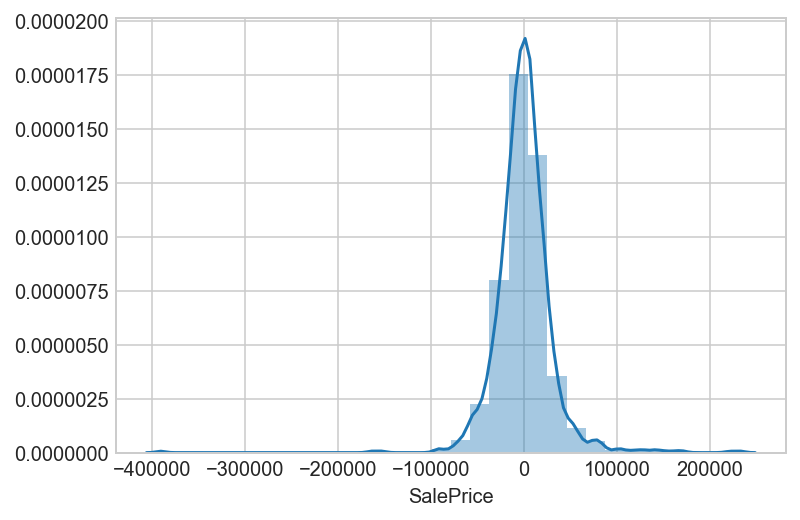

In [74]:
sns.distplot(y_train_price_residual, bins=30)

In [75]:
# res -> residual
# for residual

lm = LinearRegression()
model_res = lm.fit(Xs_train1, y_train_price_residual)

print model_res.score(Xs_train1, y_train_price_residual)
print model_res.intercept_

0.40061915333460096
1.0957526283602363


In [76]:
# doing cv to confirm on baseline score

baseline_scores_res = cross_val_score(lm, Xs_train1, y_train_price_residual, cv=10)
print 'Baseline mean: ', np.mean(baseline_scores_res)
print 'Baseline mean: ', np.std(baseline_scores_res)

Baseline mean:  -6.370916647903932e+24
Baseline mean:  1.7843382460540796e+25


In [80]:
# lasso feature selection

optimal_lasso_res = LassoCV(n_alphas=500, cv=10)
optimal_lasso_res.fit(Xs_train1, y_train_price_residual)

print 'Optimal Lasso Alpha for Residual: ', optimal_lasso_res.alpha_, '\n'

lasso_res = Lasso(alpha=optimal_lasso_res.alpha_)

lasso_scores_res = cross_val_score(lasso_res, Xs_train1, y_train_price_residual, cv=10)

print 'lasso scores for residual:', lasso_scores_res, '\n'
print 'Mean lasso scores for residual:', np.mean(lasso_scores_res)

Optimal Lasso Alpha for Residual:  1331.3918150219074 

lasso scores for residual: [-0.02115157  0.22626902  0.16866766 -0.03230289  0.02143294  0.14557284
  0.06609115  0.13406056  0.02374384 -0.32450582] 

Mean lasso scores for residual: 0.040787771505806106


In [78]:
#Lasso feature selection/variable selection alternative

lasso_res = lasso_res.fit(X_train1, y_train_price_residual)
lasso_coefs_res = pd.DataFrame({'var_res': X_train1.columns,
                          'coef_res':lasso_res.coef_,
                          'abs_coef_res':np.abs(lasso_res.coef_)})
lasso_coefs_res.sort_values('abs_coef_res', ascending=False).head()

,abs_coef_res,coef_res,var_res
53,2536.091586,-2536.091586,BsmtExposure_No
142,243.087508,-243.087508,OverallCond_5
1,29.466992,-29.466992,LowQualFinSF
0,1.109303,1.109303,BsmtUnfSF
146,0.000000,0.000000,OverallCond_9


In [81]:
# pull out cols for lasso

lasso_columns_res = list(lasso_coefs_res[lasso_coefs_res.abs_coef_res > 0]['var_res'])
len(lasso_columns_res)

4

In [86]:
# RFECV feature selection

selector_res = RFECV(lm, step=2, cv=10)
selector_res = selector_res.fit(Xs_train1, y_train_price_residual)

# print selector.support_
# print selector.ranking_

In [83]:
rfecv_columns_res = np.array(cols_res)[selector_res.support_]
rfecv_columns_res

array(['OverallCond_9'], dtype='|S21')

In [ ]:
# select k best feature

# Build the selector — we'll build one with each score type.
skb_f_res = SelectKBest(f_regression, k=10)


# Train the selector on the data.
skb_f_res.fit(Xs_train1, y_train_price_residual)


# Examine the results.
kbest_res = pd.DataFrame([cols_res, list(skb_f_res.scores_)], 
                     index=['feature_res','f_reg_res']).T.sort_values('f_reg_res', ascending=False)

kbest_res

In [ ]:
kbest_columns_res = kbest_res.feature_res.values[:20]
kbest_columns_res

In [ ]:
rfecv_scores_res = cross_val_score(lm, Xs_train1[rfecv_columns_res], y_train_price_residual, cv=10)
print 'Mean rfecv residual: ', np.mean(rfecv_scores_res)
print 'Std rfecv residual: ', np.std(rfecv_scores_res),'\n'

kbest_scores_res = cross_val_score(lm, Xs_train1[kbest_columns_res], y_train_price_residual, cv=10)
print 'Mean kbest residual: ', np.mean(kbest_scores_res)
print 'Std kbest residual: ', np.std(kbest_scores_res),'\n'

print 'Mean Lasso residual: ', np.mean(lasso_scores_res)
print 'Std Lasso residual: ', np.std(lasso_scores_res),'\n'

linreg_lasso_col_scores_res = cross_val_score(lm, Xs_train1[lasso_columns_res], y_train_price_residual, cv=10)
print 'Mean linreg with lasso col scores residual: ', np.mean(linreg_lasso_col_scores_res)
print 'Std linreg with lasso col scores residual: ', np.std(linreg_lasso_col_scores_res),'\n'

lasso_lasso_col_scores_res = cross_val_score(lasso, Xs_train1[lasso_columns_res], y_train_price_residual, cv=10)
print 'Mean lasso with lasso col scores residual: ', np.mean(lasso_lasso_col_scores_res)
print 'Std lasso with lasso col scores residual: ', np.std(lasso_lasso_col_scores_res),'\n'

In [ ]:
# l1_ratios = np.linspace(0.01, 1.0, 25)

# optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
#                             verbose=1)
# optimal_enet.fit(Xs, y)

# print optimal_enet.alpha_
# print optimal_enet.l1_ratio_

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [104]:
house_clean['SaleCondition'].value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [145]:
y3 = house_clean[['SaleCondition']]
y3['SaleCondition'] = y3['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0)
X3 = house_cat.drop('SaleCondition', axis=1)
X3 = pd.get_dummies(X3, drop_first=True)


C:\Users\Arsyad\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [148]:
X3s = pd.DataFrame(ss.fit_transform(X3), columns=X3.columns.values)

In [152]:
print y3.shape
print X3s.shape

(1450, 1)
(1450, 220)


In [150]:
X3s_train, X3s_test, y3_train, y3_test = train_test_split(X3s, y3, test_size=0.3, random_state=42)

In [160]:
#  use KNN as baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=10)
sc = knn.fit(X3_train, y3_train.values.ravel())

y3_pred_sc = knn.predict(X3_test)

print ('accuracy = {}'.format(accuracy_score(y3, y3_pred_sc)))

ValueError: Found input variables with inconsistent numbers of samples: [1450, 435]

In [ ]:
# Feature selection with RFECV and Kbest - f_classif and chi2